In [18]:
import numpy as np

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def error(tn, w, x):
    inside = sigmoid(np.dot(w, x))
    return -(tn * np.log(inside) + (1 - tn) * np.log(1 - inside))

def error_gradient(tn, w, x, lamb=0):
    norm = np.linalg.norm(w, ord=1)
    return x * (sigmoid(np.dot(w, x)) - tn) + lamb * norm

def sgd(X, Y, lr, epochs=1000):
    w = np.zeros_like(X[0])
    err_avg = []

    for _ in range(epochs):
        err = []
        for (x, y) in zip(X, Y):
            w = w - lr*error_gradient(y, w, x)
            err.append(error(y, w, x))
        err_avg.append(np.mean(err))
    
    return w, err_avg

In [19]:
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X, y = load_digits(return_X_y=True, n_class=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# model = LogisticRegression(random_state=0).fit(X_train, y_train)
# model.score(X_test, y_test)

In [20]:
l = np.logspace(-5, 5) # lambda values to test
l = [0.1]

def logistic_regression(X, y, lambdas):
    weights, errors = [], []
    for l in lambdas:
        w, err = sgd(X, y, 0.005)
        weights.append(w)
        errors.append(err)
    return weights, errors

weights, errors = logistic_regression(X_train, y_train, l)
# weights

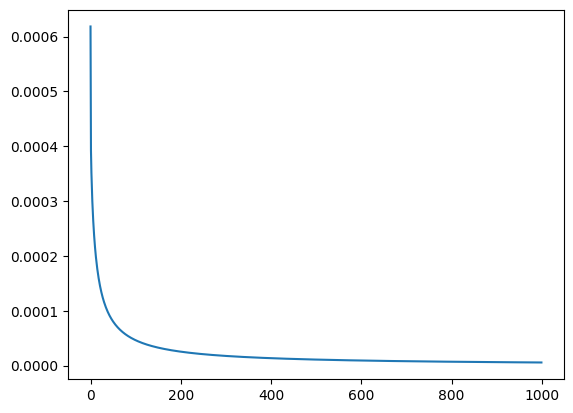

In [21]:
import matplotlib.pyplot as plt

len(errors[0])

plt.plot(np.arange(1000), errors[0])
plt.show()